# Figure 1


## Caption
Maximum phosphorous concentration, 2007-2010 average summer. The 11 rivers are marked and segregated in to north, east, and west groups. The 30 m depth contour (gray) is typically for delineation of the near-shore. The model does not include a mean background phosphorus concentration, only the phosphorus delivered from rivers since 1 January of the simulation year. In recent years, the background value has been estimated at 2-4 $\mu gPL^{-1}$ [[Midas et al., 2010]](https://pdfs.semanticscholar.org/b216/1fafea1ad3ecfb7798716e4879970a2c0905.pdf).

In [11]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.size']=12
rcParams['xtick.labelsize']=16
rcParams['ytick.labelsize']=16
rcParams['axes.labelsize']=12
rcParams['axes.titlesize']=12

import numpy as np
import xarray as xr
import pandas as pd
import cmocean
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.io import shapereader
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper")

## 1 .Load dadta

In [2]:
data_clean='/Users/gloege/Documents/Projects/MITgcm-Michigan-Phosphorus/data/clean/'
ds_jja = xr.open_dataset(f'{data_clean}phosphorus_max_JJA.nc')

## 2. Plot data

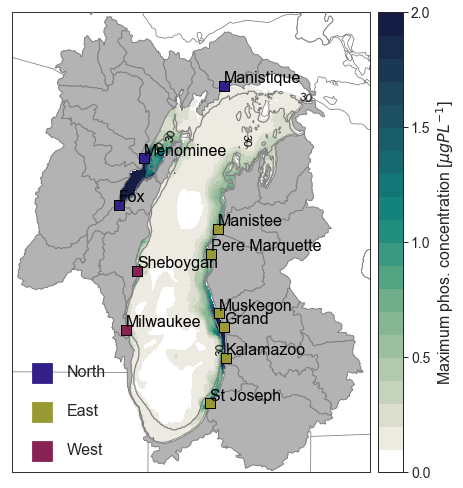

In [24]:
### ==============================================================
### Define grids
### ==============================================================
fig = plt.figure(figsize=(7,11))
projection = ccrs.Mercator()
axes_class = (GeoAxes, dict(map_projection=projection))
grid = AxesGrid(fig, 111, axes_class=axes_class,
                share_all=False,
                nrows_ncols = (1, 1),
                axes_pad = 0.2,
                cbar_location = 'right',
                cbar_mode="edge",
                cbar_pad = 0.1,
                cbar_size = '7%',
                label_mode = '')  # note the empty label_mode
### should really change ax to grid[0] everywhere
ax=grid[0]

### ==============================================================
### Set boundaries
### ==============================================================
#ax.set_extent([-84.75, -88.25, 41.5, 46.25]) ### Michigan
#ax.set_extent([-90.25, -83.5, 41.25, 46.75])  ### Watershed
ax.set_extent([-89.8, -83.8, 41.25, 46.8])  ### Watershed

### ==============================================================
### Colormap of data
### ============================================================== 
# define the colormap
vmin = 0
vmax = 2
cmap = cmocean.cm.tempo
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1,1,1,1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(vmin,vmax,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

pos = ax.pcolormesh(ds_jja['X'].values, ds_jja['Y'].values, 
          ds_jja['phos_max_JJA'].where(ds_jja['phos_max_JJA']>0).values, 
           cmap = cmap, 
           norm = norm,
           vmin = vmin, 
           vmax = vmax,
           transform=ccrs.PlateCarree(),
           zorder = 2)

### ==============================================================
### Create a feature for States/Admin 1 
### regions at 1:50m from Natural Earth
### ==============================================================
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', facecolor='none')


### ==============================================================
### Create a feature for lakes at 1:50m from Natural Earth
### ==============================================================
lakes_50m = cfeature.NaturalEarthFeature(
    category='physical',
    name='lakes',
    scale='10m',
    facecolor='none')
ax.add_feature(lakes_50m, edgecolor='gray', facecolor='none', zorder=3)


### ==============================================================
### Plot Lake Michigan watershed
### ==============================================================
dir_shapes = '/Users/gloege/Documents/Projects/MITgcm-Michigan-Phosphorus/data/shapefiles/'
watershed_shp = f'{dir_shapes}sub-watershed/glwsheds.shp'
reader = shapereader.Reader(watershed_shp)
lakes = reader.records()

for lake in lakes:
    if lake.attributes['LAKEBASIN'] == 'Michigan':
        ax.add_geometries(lake.geometry, 
                          ccrs.PlateCarree(), 
                          facecolor=(0.7, 0.7, 0.7),
                          edgecolor=(0.5, 0.5, 0.5),
                          linewidths=1.,
                          label=lake.attributes['LAKEBASIN'], zorder=4)
        
### ==============================================================
### Add 30m contour
### ==============================================================
dir_raw='/Users/gloege/Documents/Projects/MITgcm-Michigan-Phosphorus/data/raw/'
grid_nc = f'{dir_raw}grid_lake_michigan.nc'
ds_grid = xr.open_dataset(grid_nc, mask_and_scale=True)
cs = ax.contour(ds_grid['X'].values, ds_grid['Y'].values, ds_grid['Depth'].values, 
                levels=[30],
                colors=((0.5, 0.5, 0.5), (1, 1, 1)),
                transform=ccrs.PlateCarree(), 
                zorder=2)
ax.clabel(cs, inline=True, fmt='%1.0f', fontsize=12, colors='k')


### ==============================================================
### Add river mouth
### ==============================================================
rivers_list=['Milwaukee', 'Sheboygan', 'Fox', 'Menominee', 
             'Manistique', 'Manistee', 'Pere Marquette', 'Muskegon', 
             'Grand', 'Kalamazoo', 'St Joseph']

### River colors
N_col = list(map(lambda x: x / 255, [51, 31, 136]))
SE_col = list(map(lambda x: x / 255, [153, 153, 51]))
SW_col = list(map(lambda x: x / 255, [136, 34, 85]))
river_cols = [SW_col, SW_col, N_col, N_col, N_col, 
              SE_col, SE_col, SE_col, SE_col, SE_col, SE_col]

### Read rivers
dir_raw='/Users/gloege/Documents/Projects/MITgcm-Michigan-Phosphorus/data/raw/'
csv_rivers_LM = f'{dir_raw}wrtds_LM_stations.csv'
    
df = pd.read_csv(csv_rivers_LM, index_col=0).loc[rivers_list, :]
ax.scatter(df['lonMouth'].values, df['latMouth'].values,
              s=100,
              c=river_cols,
              marker='s',
              alpha=1,
              edgecolors='k',
              linewidths=1,
              transform=ccrs.PlateCarree(),
              zorder=5)


### ==============================================================
### Add river mouth labels
### ==============================================================
# Loop over sites and plot as +
df = pd.read_csv(csv_rivers_LM)
df = df[df['river'].isin(rivers_list)]
for ln, lt, lb in zip(df['lonMouth'].values, df['latMouth'].values, df['river']):
    ax.text(ln, lt, lb,
             fontsize=16,
             fontweight=10,
             ha='left',
             va='bottom',
             color='k',
             transform=ccrs.PlateCarree(),
             zorder=5)  

### ==============================================================
### Add a legend
### ==============================================================
north = ax.scatter(-999, -999, 
          s=1, 
          c=N_col, 
          marker='s', 
          label='North')
southEast = ax.scatter(-999, -999, 
          s=1, 
          c=SE_col, 
          marker='s', 
          label='East')
southWest = ax.scatter(-999, -999, 
          s=1, 
          c=SW_col, 
          marker='s', 
          label='West')

ax.legend(handles=[north, southEast, southWest], 
          loc=3, 
          fontsize=16, 
          markerscale=20, 
          handletextpad=0.5, 
          labelspacing=1.5,
          frameon=False)

### ==============================================================
### Add colorbar
### Better to use plt with reference to cax 
### than to grid.cbar_axes[0].colorbar(sub)
### since it is clunky as all get
### ==============================================================
cbar = plt.colorbar(pos, cax=grid.cbar_axes[0])
cbar.set_label(r'Maximum phos. concentration [$\mu g P L^{-1}$]', fontsize=16)
cbar.set_ticks(np.arange(0, 2.2, 0.5))
cbar.ax.tick_params(labelsize=14) 
